See https://github.com/rgov/apriltag-pdfs
and https://www.firstinspires.org/robotics/frc/blog/2022-control-system-reporting-2023-updates-and-beta-testing

We'll try out this library: https://github.com/pupil-labs/apriltags
Calibration script from # https://github.com/swatbotics/apriltag/blob/master/python/calibrate_camera.py

April Tags for FRC will all be tag36h11 family. The total area should be around 8.5in^2, meaning the black canvas is around 6.5in^2

### You should only the cell below ONCE to install the pupil-apriltags library. This cell patches a bug in the packages that only affect Windows.

In [11]:
# https://github.com/pupil-labs/apriltags/pull/48
# See https://github.com/pupil-labs/apriltags/issues/53

!pip install pupil-apriltags==1.0.4.post8
import pupil_apriltags as atgs
import os
if os.name == 'nt':
    !pip install pupil-pthreads-win
    init_path = atgs.__file__
    at_dir = os.path.dirname(init_path)
    target = at_dir + '\\bindings.py'
    lines = None
    with open(target, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        lines[314] = "        if platform.system() == \"Windows\":\n"
        
    with open(target, 'w', encoding='utf-8') as file:
        file.writelines(lines)

    from importlib import reload
    reload(atgs)
else:
    print("Not on windows. Skipping patch.")
    


In [2]:
# https://github.com/pupil-labs/apriltags/pull/48
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Copying parameters from the calibration script result
fx, fy, cx, cy = (995.5027920759295, 1001.3658254510876, 618.5636884544525, 369.80679933903093)

In [4]:
import logging

detector = atgs.Detector(
   families="tag36h11",
   nthreads=4,
   quad_decimate=1.0,
   quad_sigma=0.0,
   refine_edges=1,
   decode_sharpening=0.25,
   debug=0
)

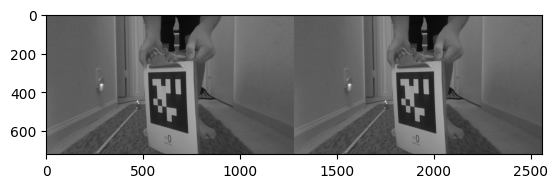

In [5]:
# On 8.5in paper, black region about 6.6in wide
im0 = cv2.cvtColor(cv2.imread('dataset/2ft_rotated.jpg'), cv2.COLOR_BGR2GRAY)

# Also, correct the image using the camera calibration matrix and show it
mtx = np.zeros((3,3))
mtx[0, 0] = fx
mtx[1, 1] = fy
mtx[0, 2] = cx
mtx[1, 2] = cy
mtx[2, 2] = 1
dst = cv2.undistort(im0, mtx, np.zeros(5), None)

# I can't really tell the difference between these images at this size.
comparison = cv2.hconcat((im0, dst))
# cv2.imwrite('comparison.png', comparison)
plt.imshow(comparison, cmap = 'gray')

In [6]:
res = detector.detect(
    im0,
    estimate_tag_pose=True,
    camera_params=(fx, fy, cx, cy),
    tag_size = 0.168 # meter, width of the black box
)
print(res)

[Detection object:
tag_family = b'tag36h11'
tag_id = 0
hamming = 0
decision_margin = 51.23603820800781
homography = [[ 3.08084898e+01  1.18206644e+01  6.19631504e+02]
 [-3.42058506e+01  1.46851113e+02  4.42650315e+02]
 [-1.05782430e-01  8.49574432e-03  1.00000000e+00]]
center = [619.63150444 442.65031504]
corners = [[539.04284668 559.74108887]
 [733.63342285 615.14056396]
 [721.01568604 295.34481812]
 [525.84466553 300.74642944]]
pose_R = [[ 0.66925157  0.0457219   0.74162784]
 [ 0.0333082   0.9952556  -0.09141586]
 [-0.74228896  0.08588249  0.66455345]]
pose_t = [[5.57615803e-04]
 [4.26192456e-02]
 [5.81546905e-01]]
pose_err = 2.2609865414150316e-07
]


In [7]:
# pose_t is 3D translation vector.
# Since I tried to center the tag, only one component has any significant magnitude
# res is a list and has more elements if multiple tags are in the scene.
(res[0].pose_t[2]) / .3048 # meters to ft

array([1.90796229])

Overall this is pretty good, and the result is within 5% of the nominal value, keeping in mind that my setup was also imprecise.

[[[539 559]]

 [[733 615]]

 [[721 295]]

 [[525 300]]]


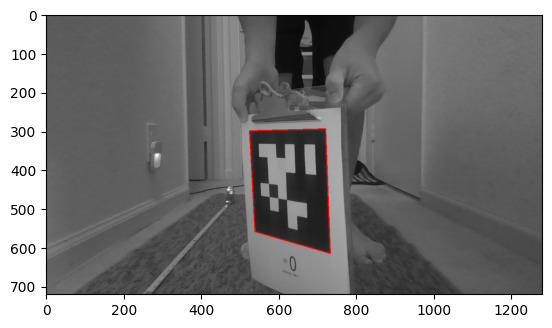

In [8]:
corners = res[0].corners.astype(np.int32).reshape(-1, 1, 2)
print(corners)
withbox = cv2.polylines(
    cv2.cvtColor(im0, cv2.COLOR_GRAY2RGB),
    [corners],
    isClosed=True,
    color = (255,0,0),
    thickness = 2)

plt.imshow(withbox)

What about the angles? Well...
https://github.com/AprilRobotics/apriltag/issues/90
https://github.com/AprilRobotics/apriltag/pull/265
https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html

In [9]:
from scipy.spatial.transform import Rotation as R
pose_r = res[0].pose_R
R.from_matrix(pose_r).as_euler('zxy', degrees=True)

array([ 1.91680145,  5.24506545, 48.13730701])